In [225]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [226]:
def f(x):
    return 3*x**2 - 4*x + 5

In [227]:
f(3.0)

20.0

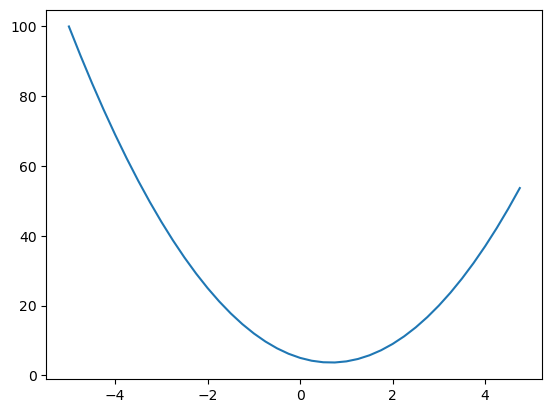

In [228]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [229]:
h = 0.000001
x = 2/3
(f( x + h ) - f(x))/h

2.999378523327323e-06

In [230]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [231]:
h = 0.0001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [232]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)),"only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [233]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [234]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [235]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

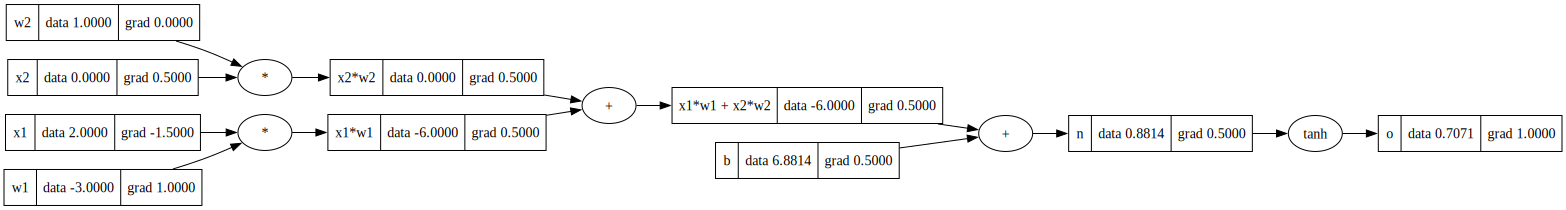

In [236]:
draw_dot(o)

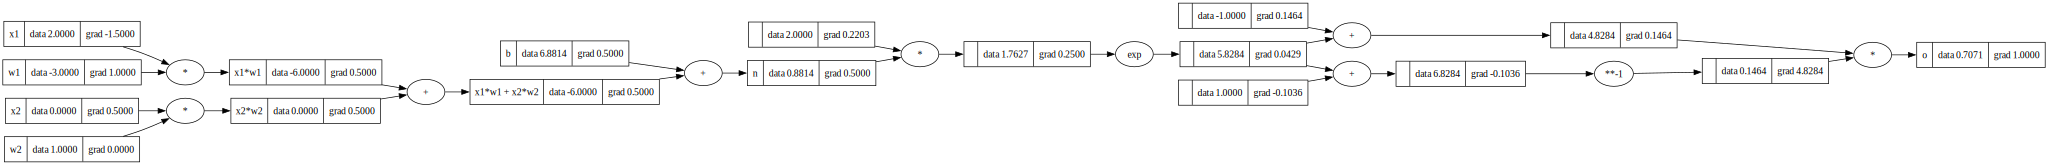

In [237]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----
o.label = 'o'
o.backward()
draw_dot(o)

In [238]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [458]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w + x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)),start = self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0]  if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return x  

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9328607923294201)

In [459]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9328607923294201),
 Value(data=-0.6784534145662312),
 Value(data=-0.8799579395145914),
 Value(data=-0.9072607349629509)]

In [461]:
for k in range(10000):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)),start=Value(0))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.0185762805976916e-05
1 3.0182646997105248e-05
2 3.0179531821684994e-05
3 3.017641727952411e-05
4 3.017330337043134e-05
5 3.0170190094213215e-05
6 3.016707745067854e-05
7 3.0163965439635933e-05
8 3.0160854060892276e-05
9 3.0157743314256435e-05
10 3.0154633199538314e-05
11 3.015152371654423e-05
12 3.01484148650844e-05
13 3.0145306644962796e-05
14 3.0142199055995195e-05
15 3.0139092097985987e-05
16 3.0135985770743796e-05
17 3.0132880074080075e-05
18 3.0129775007800214e-05
19 3.012667057171643e-05
20 3.0123566765637802e-05
21 3.0120463589370403e-05
22 3.0117361042725918e-05
23 3.0114259125514364e-05
24 3.0111157837543074e-05
25 3.010805717862386e-05
26 3.010495714856417e-05
27 3.010185774717468e-05
28 3.009875897426472e-05
29 3.0095660829643392e-05
30 3.0092563313124234e-05
31 3.00894664245126e-05
32 3.008637016362102e-05
33 3.0083274530257495e-05
34 3.008017952423632e-05
35 3.0077085145364274e-05
36 3.0073991393451526e-05
37 3.007089826831042e-05
38 3.006780576975066e-05
39 3.00647138

374 2.906303185338249e-05
375 2.9060140190545634e-05
376 2.9057249094370323e-05
377 2.905435856469225e-05
378 2.9051468601341338e-05
379 2.904857920415434e-05
380 2.904569037296459e-05
381 2.904280210761118e-05
382 2.9039914407923455e-05
383 2.903702727373634e-05
384 2.90341407048871e-05
385 2.903125470120882e-05
386 2.9028369262538875e-05
387 2.9025484388708588e-05
388 2.902260007955594e-05
389 2.9019716334914286e-05
390 2.9016833154618492e-05
391 2.9013950538504385e-05
392 2.901106848640821e-05
393 2.9008186998164563e-05
394 2.90053060736075e-05
395 2.900242571257321e-05
396 2.8999545914896992e-05
397 2.8996666680415996e-05
398 2.899378800896501e-05
399 2.8990909900379057e-05
400 2.89880323544942e-05
401 2.8985155371147366e-05
402 2.8982278950172858e-05
403 2.897940309140686e-05
404 2.897652779468565e-05
405 2.8973653059844417e-05
406 2.897077888672261e-05
407 2.8967905275152027e-05
408 2.896503222497172e-05
409 2.8962159736016357e-05
410 2.8959287808122642e-05
411 2.895641644112984e

742 2.8035846902879746e-05
743 2.8033153088687635e-05
744 2.803045978427909e-05
745 2.802776698950973e-05
746 2.802507470423209e-05
747 2.8022382928307854e-05
748 2.8019691661588644e-05
749 2.801700090393278e-05
750 2.801431065519646e-05
751 2.8011620915234007e-05
752 2.800893168390682e-05
753 2.8006242961065304e-05
754 2.80035547465693e-05
755 2.8000867040275486e-05
756 2.7998179842040073e-05
757 2.799549315171902e-05
758 2.799280696917023e-05
759 2.7990121294248396e-05
760 2.7987436126812055e-05
761 2.7984751466717827e-05
762 2.7982067313822496e-05
763 2.7979383667984435e-05
764 2.797670052905836e-05
765 2.797401789690308e-05
766 2.7971335771373745e-05
767 2.7968654152329676e-05
768 2.796597303962707e-05
769 2.7963292433123144e-05
770 2.796061233267653e-05
771 2.7957932738142362e-05
772 2.7955253649380555e-05
773 2.7952575066248153e-05
774 2.7949896988602592e-05
775 2.7947219416298853e-05
776 2.7944542349199617e-05
777 2.794186578715859e-05
778 2.7939189730033725e-05
779 2.7936514177

1057 2.7211784973141475e-05
1058 2.7209244889184313e-05
1059 2.7206705272206396e-05
1060 2.7204166122078183e-05
1061 2.72016274386729e-05
1062 2.7199089221862576e-05
1063 2.719655147151756e-05
1064 2.7194014187512033e-05
1065 2.71914773697167e-05
1066 2.718894101800461e-05
1067 2.718640513224801e-05
1068 2.718386971231756e-05
1069 2.7181334758087776e-05
1070 2.7178800269429618e-05
1071 2.7176266246214764e-05
1072 2.7173732688319106e-05
1073 2.7171199595610908e-05
1074 2.716866696796364e-05
1075 2.7166134805252705e-05
1076 2.716360310734761e-05
1077 2.716107187412141e-05
1078 2.715854110544762e-05
1079 2.7156010801201163e-05
1080 2.7153480961251575e-05
1081 2.7150951585470963e-05
1082 2.7148422673735725e-05
1083 2.7145894225916166e-05
1084 2.7143366241887133e-05
1085 2.7140838721519788e-05
1086 2.7138311664688215e-05
1087 2.7135785071265802e-05
1088 2.7133258941125126e-05
1089 2.7130733274139667e-05
1090 2.7128208070182356e-05
1091 2.7125683329127598e-05
1092 2.7123159050846543e-05
1093

1420 2.631943561176447e-05
1421 2.631705697783668e-05
1422 2.6314678767287798e-05
1423 2.631230098000798e-05
1424 2.6309923615883158e-05
1425 2.6307546674800423e-05
1426 2.6305170156648964e-05
1427 2.630279406131411e-05
1428 2.6300418388684784e-05
1429 2.6298043138649873e-05
1430 2.6295668311096647e-05
1431 2.629329390591323e-05
1432 2.6290919922985553e-05
1433 2.6288546362204454e-05
1434 2.6286173223454697e-05
1435 2.6283800506626012e-05
1436 2.6281428211608677e-05
1437 2.6279056338285854e-05
1438 2.627668488655056e-05
1439 2.6274313856286283e-05
1440 2.6271943247384997e-05
1441 2.6269573059734067e-05
1442 2.6267203293220783e-05
1443 2.626483394773339e-05
1444 2.6262465023160983e-05
1445 2.6260096519393948e-05
1446 2.625772843631602e-05
1447 2.625536077381985e-05
1448 2.625299353179235e-05
1449 2.6250626710121666e-05
1450 2.624826030869702e-05
1451 2.6245894327407195e-05
1452 2.624352876613925e-05
1453 2.6241163624784232e-05
1454 2.6238798903229234e-05
1455 2.6236434601364022e-05
1456

1762 2.55299088741914e-05
1763 2.5527668731191714e-05
1764 2.5525428975315658e-05
1765 2.5523189606460977e-05
1766 2.5520950624527043e-05
1767 2.551871202941857e-05
1768 2.5516473821029847e-05
1769 2.551423599926435e-05
1770 2.551199856402314e-05
1771 2.5509761515207015e-05
1772 2.5507524852713277e-05
1773 2.550528857644356e-05
1774 2.5503052686299723e-05
1775 2.5500817182179756e-05
1776 2.5498582063988858e-05
1777 2.549634733162273e-05
1778 2.549411298498422e-05
1779 2.5491879023972504e-05
1780 2.5489645448490248e-05
1781 2.548741225843737e-05
1782 2.54851794537131e-05
1783 2.5482947034221837e-05
1784 2.5480714999860767e-05
1785 2.5478483350530982e-05
1786 2.5476252086136086e-05
1787 2.547402120657299e-05
1788 2.54717907117478e-05
1789 2.5469560601557356e-05
1790 2.546733087590372e-05
1791 2.546510153468796e-05
1792 2.5462872577812683e-05
1793 2.546064400517615e-05
1794 2.5458415816682603e-05
1795 2.5456188012230304e-05
1796 2.545396059172208e-05
1797 2.5451733555059382e-05
1798 2.544

2183 2.4619843921854056e-05
2184 2.4617758334722015e-05
2185 2.461567309553277e-05
2186 2.4613588204202505e-05
2187 2.4611503660640767e-05
2188 2.4609419464765064e-05
2189 2.460733561648456e-05
2190 2.460525211571482e-05
2191 2.460316896237079e-05
2192 2.4601086156363863e-05
2193 2.4599003697608876e-05
2194 2.4596921586016677e-05
2195 2.4594839821506116e-05
2196 2.4592758403985277e-05
2197 2.459067733337016e-05
2198 2.4588596609576686e-05
2199 2.4586516232515978e-05
2200 2.4584436202102257e-05
2201 2.458235651824835e-05
2202 2.45802771808707e-05
2203 2.4578198189879937e-05
2204 2.45761195451925e-05
2205 2.4574041246720736e-05
2206 2.4571963294380683e-05
2207 2.4569885688083917e-05
2208 2.456780842774615e-05
2209 2.456573151328011e-05
2210 2.456365494460025e-05
2211 2.4561578721621075e-05
2212 2.4559502844255766e-05
2213 2.4557427312420442e-05
2214 2.4555352126026252e-05
2215 2.4553277284989932e-05
2216 2.4551202789226698e-05
2217 2.4549128638645348e-05
2218 2.4547054833165752e-05
2219 

2536 2.3904636692555002e-05
2537 2.39026687483033e-05
2538 2.3900701123113463e-05
2539 2.3898733816905343e-05
2540 2.3896766829605852e-05
2541 2.389480016113505e-05
2542 2.3892833811416048e-05
2543 2.3890867780373567e-05
2544 2.3888902067929294e-05
2545 2.3886936674007127e-05
2546 2.3884971598527768e-05
2547 2.3883006841416514e-05
2548 2.388104240259303e-05
2549 2.3879078281985636e-05
2550 2.3877114479513815e-05
2551 2.3875150995102022e-05
2552 2.3873187828671158e-05
2553 2.3871224980147297e-05
2554 2.386926244945179e-05
2555 2.3867300236508954e-05
2556 2.3865338341241477e-05
2557 2.3863376763571237e-05
2558 2.3861415503423793e-05
2559 2.3859454560721844e-05
2560 2.38574939353884e-05
2561 2.3855533627345072e-05
2562 2.3853573636517624e-05
2563 2.385161396283044e-05
2564 2.3849654606202687e-05
2565 2.384769556656152e-05
2566 2.384573684382841e-05
2567 2.3843778437928292e-05
2568 2.384182034878409e-05
2569 2.3839862576317837e-05
2570 2.3837905120456255e-05
2571 2.3835947981121165e-05
257

2901 2.3206929266786104e-05
2902 2.3205072843861377e-05
2903 2.3203216713391957e-05
2904 2.3201360875309836e-05
2905 2.3199505329544864e-05
2906 2.3197650076028254e-05
2907 2.3195795114691455e-05
2908 2.3193940445467625e-05
2909 2.3192086068285817e-05
2910 2.3190231983079248e-05
2911 2.3188378189775438e-05
2912 2.318652468831232e-05
2913 2.318467147861556e-05
2914 2.3182818560618047e-05
2915 2.318096593425251e-05
2916 2.3179113599452005e-05
2917 2.3177261556143685e-05
2918 2.3175409804262798e-05
2919 2.31735583437376e-05
2920 2.3171707174502363e-05
2921 2.3169856296487616e-05
2922 2.3168005709626886e-05
2923 2.3166155413847005e-05
2924 2.316430540908658e-05
2925 2.316245569527067e-05
2926 2.3160606272334573e-05
2927 2.3158757140209345e-05
2928 2.3156908298827193e-05
2929 2.3155059748118573e-05
2930 2.315321148801573e-05
2931 2.315136351845134e-05
2932 2.3149515839355434e-05
2933 2.3147668450662715e-05
2934 2.3145821352303068e-05
2935 2.3143974544208466e-05
2936 2.314212802631211e-05
29

3215 2.2638040926901177e-05
3216 2.263627306248408e-05
3217 2.2634505469944896e-05
3218 2.263273814922412e-05
3219 2.26309711002556e-05
3220 2.2629204322981463e-05
3221 2.2627437817335966e-05
3222 2.262567158325598e-05
3223 2.2623905620681745e-05
3224 2.2622139929550434e-05
3225 2.2620374509797774e-05
3226 2.261860936136475e-05
3227 2.2616844484187652e-05
3228 2.261507987820377e-05
3229 2.261331554335103e-05
3230 2.2611551479566526e-05
3231 2.2609787686790617e-05
3232 2.2608024164959785e-05
3233 2.2606260914011154e-05
3234 2.2604497933882246e-05
3235 2.2602735224513044e-05
3236 2.2600972785839505e-05
3237 2.259921061780176e-05
3238 2.2597448720335805e-05
3239 2.2595687093379296e-05
3240 2.2593925736872486e-05
3241 2.259216465075182e-05
3242 2.2590403834956613e-05
3243 2.258864328942349e-05
3244 2.2586883014090236e-05
3245 2.258512300889718e-05
3246 2.258336327377999e-05
3247 2.2581603808677956e-05
3248 2.2579844613529386e-05
3249 2.2578085688272487e-05
3250 2.2576327032845258e-05
3251 

3567 2.203211015688122e-05
3568 2.2030434271646724e-05
3569 2.2028758637452517e-05
3570 2.2027083254239587e-05
3571 2.2025408121955536e-05
3572 2.2023733240542985e-05
3573 2.202205860994237e-05
3574 2.2020384230102897e-05
3575 2.2018710100965698e-05
3576 2.2017036222474757e-05
3577 2.2015362594573743e-05
3578 2.201368921720792e-05
3579 2.201201609032118e-05
3580 2.201034321385699e-05
3581 2.200867058775968e-05
3582 2.200699821197317e-05
3583 2.2005326086442e-05
3584 2.2003654211108767e-05
3585 2.2001982585918766e-05
3586 2.2000311210818298e-05
3587 2.1998640085746256e-05
3588 2.1996969210651187e-05
3589 2.1995298585476055e-05
3590 2.1993628210165177e-05
3591 2.199195808466291e-05
3592 2.1990288208912747e-05
3593 2.1988618582858534e-05
3594 2.1986949206446756e-05
3595 2.1985280079618766e-05
3596 2.1983611202322792e-05
3597 2.198194257449873e-05
3598 2.1980274196094523e-05
3599 2.1978606067049945e-05
3600 2.197693818731479e-05
3601 2.1975270556832034e-05
3602 2.1973603175543374e-05
3603 

3913 2.146686258071119e-05
3914 2.1465270315923693e-05
3915 2.1463678283709382e-05
3916 2.1462086484019147e-05
3917 2.1460494916804226e-05
3918 2.1458903582012252e-05
3919 2.1457312479591815e-05
3920 2.1455721609494845e-05
3921 2.1454130971667876e-05
3922 2.1452540566062592e-05
3923 2.1450950392626752e-05
3924 2.1449360451310805e-05
3925 2.1447770742064077e-05
3926 2.14461812648351e-05
3927 2.1444592019573003e-05
3928 2.144300300623017e-05
3929 2.1441414224753785e-05
3930 2.1439825675092004e-05
3931 2.1438237357196313e-05
3932 2.143664927101628e-05
3933 2.143506141650248e-05
3934 2.1433473793602438e-05
3935 2.1431886402265605e-05
3936 2.1430299242442755e-05
3937 2.142871231408369e-05
3938 2.1427125617136698e-05
3939 2.1425539151552778e-05
3940 2.142395291728062e-05
3941 2.1422366914270064e-05
3942 2.1420781142471495e-05
3943 2.141919560183276e-05
3944 2.14176102923058e-05
3945 2.1416025213840028e-05
3946 2.1414440366384144e-05
3947 2.1412855749888165e-05
3948 2.141127136430139e-05
3949

4261 2.0926452408333736e-05
4262 2.0924938117700718e-05
4263 2.092342404285092e-05
4264 2.0921910183737534e-05
4265 2.092039654031594e-05
4266 2.0918883112538912e-05
4267 2.0917369900360948e-05
4268 2.0915856903736423e-05
4269 2.0914344122621583e-05
4270 2.0912831556966124e-05
4271 2.0911319206726657e-05
4272 2.0909807071859155e-05
4273 2.0908295152314163e-05
4274 2.0906783448048216e-05
4275 2.0905271959015265e-05
4276 2.090376068517045e-05
4277 2.0902249626465597e-05
4278 2.0900738782857467e-05
4279 2.0899228154299013e-05
4280 2.0897717740744293e-05
4281 2.0896207542147775e-05
4282 2.0894697558466766e-05
4283 2.089318778965149e-05
4284 2.089167823565782e-05
4285 2.0890168896439665e-05
4286 2.0888659771953197e-05
4287 2.088715086215147e-05
4288 2.0885642166989097e-05
4289 2.088413368642069e-05
4290 2.088262542039986e-05
4291 2.0881117368881645e-05
4292 2.087960953181975e-05
4293 2.0878101909171398e-05
4294 2.0876594500887427e-05
4295 2.087508730692543e-05
4296 2.087358032723816e-05
429

4591 2.0438184043065377e-05
4592 2.0436738544343143e-05
4593 2.043529324693747e-05
4594 2.043384815080641e-05
4595 2.0432403255908317e-05
4596 2.0430958562201385e-05
4597 2.0429514069644072e-05
4598 2.0428069778194255e-05
4599 2.042662568781127e-05
4600 2.0425181798450468e-05
4601 2.042373811007281e-05
4602 2.042229462263458e-05
4603 2.0420851336095832e-05
4604 2.0419408250412794e-05
4605 2.041796536554541e-05
4606 2.0416522681452704e-05
4607 2.0415080198091027e-05
4608 2.041363791541875e-05
4609 2.0412195833395314e-05
4610 2.0410753951979156e-05
4611 2.0409312271128257e-05
4612 2.040787079079956e-05
4613 2.040642951095386e-05
4614 2.0404988431549398e-05
4615 2.040354755254182e-05
4616 2.0402106873891748e-05
4617 2.0400666395556705e-05
4618 2.039922611749603e-05
4619 2.039778603966782e-05
4620 2.0396346162028986e-05
4621 2.0394906484541487e-05
4622 2.039346700716091e-05
4623 2.0392027729846797e-05
4624 2.0390588652557484e-05
4625 2.0389149775250566e-05
4626 2.0387711097885558e-05
4627 

4935 1.9952534395986922e-05
4936 1.995115575696879e-05
4937 1.9949777305529297e-05
4938 1.9948399041629024e-05
4939 1.9947020965228896e-05
4940 1.994564307629417e-05
4941 1.994426537478543e-05
4942 1.9942887860663733e-05
4943 1.994151053389062e-05
4944 1.994013339442987e-05
4945 1.9938756442243375e-05
4946 1.9937379677291488e-05
4947 1.9936003099536493e-05
4948 1.9934626708941344e-05
4949 1.9933250505467573e-05
4950 1.993187448907835e-05
4951 1.9930498659734704e-05
4952 1.9929123017397245e-05
4953 1.99277475620308e-05
4954 1.992637229359437e-05
4955 1.9924997212052654e-05
4956 1.992362231736833e-05
4957 1.992224760949964e-05
4958 1.992087308841312e-05
4959 1.9919498754068085e-05
4960 1.99181246064271e-05
4961 1.991675064545386e-05
4962 1.991537687110805e-05
4963 1.9914003283354016e-05
4964 1.991262988215119e-05
4965 1.991125666746605e-05
4966 1.990988363925706e-05
4967 1.9908510797487146e-05
4968 1.9907138142119462e-05
4969 1.9905765673116164e-05
4970 1.9904393390439928e-05
4971 1.9903

5283 1.94838343793641e-05
5284 1.9482518787159157e-05
5285 1.9481203369874884e-05
5286 1.9479888127476978e-05
5287 1.947857305992793e-05
5288 1.9477258167195084e-05
5289 1.9475943449243312e-05
5290 1.9474628906036793e-05
5291 1.947331453754279e-05
5292 1.9472000343726864e-05
5293 1.947068632455117e-05
5294 1.9469372479983888e-05
5295 1.9468058809991115e-05
5296 1.946674531453408e-05
5297 1.9465431993582884e-05
5298 1.9464118847099658e-05
5299 1.9462805875052085e-05
5300 1.9461493077403e-05
5301 1.946018045412183e-05
5302 1.945886800516899e-05
5303 1.9457555730513986e-05
5304 1.9456243630120064e-05
5305 1.9454931703953403e-05
5306 1.9453619951979833e-05
5307 1.9452308374164843e-05
5308 1.9450996970473298e-05
5309 1.9449685740871296e-05
5310 1.94483746853226e-05
5311 1.9447063803793997e-05
5312 1.9445753096252627e-05
5313 1.9444442562661765e-05
5314 1.94431322029871e-05
5315 1.9441822017196833e-05
5316 1.944051200525272e-05
5317 1.9439202167121658e-05
5318 1.943789250277168e-05
5319 1.94

5624 1.9045135112405596e-05
5625 1.9043877213971747e-05
5626 1.9042619479133106e-05
5627 1.9041361907857933e-05
5628 1.9040104500114237e-05
5629 1.9038847255870974e-05
5630 1.9037590175095112e-05
5631 1.9036333257754108e-05
5632 1.9035076503819406e-05
5633 1.903381991325639e-05
5634 1.903256348603565e-05
5635 1.9031307222124156e-05
5636 1.9030051121490287e-05
5637 1.9028795184102522e-05
5638 1.9027539409928988e-05
5639 1.9026283798937462e-05
5640 1.9025028351097676e-05
5641 1.9023773066376932e-05
5642 1.9022517944744784e-05
5643 1.902126298617068e-05
5644 1.902000819061775e-05
5645 1.9018753558059837e-05
5646 1.901749908846203e-05
5647 1.9016244781794432e-05
5648 1.901499063802597e-05
5649 1.901373665712412e-05
5650 1.9012482839055014e-05
5651 1.9011229183791622e-05
5652 1.900997569129995e-05
5653 1.900872236154814e-05
5654 1.900746919450552e-05
5655 1.900621619014085e-05
5656 1.9004963348421105e-05
5657 1.9003710669315795e-05
5658 1.900245815279355e-05
5659 1.9001205798823278e-05
5660

5970 1.8619453796325833e-05
5971 1.86182506610206e-05
5972 1.8617047678795328e-05
5973 1.8615844849620026e-05
5974 1.8614642173464854e-05
5975 1.8613439650304348e-05
5976 1.8612237280105233e-05
5977 1.861103506284171e-05
5978 1.860983299848235e-05
5979 1.8608631086999718e-05
5980 1.8607429328362192e-05
5981 1.860622772254465e-05
5982 1.8605026269514913e-05
5983 1.8603824969246647e-05
5984 1.860262382170702e-05
5985 1.860142282687211e-05
5986 1.8600221984709675e-05
5987 1.8599021295190342e-05
5988 1.859782075828632e-05
5989 1.8596620373967864e-05
5990 1.8595420142207463e-05
5991 1.8594220062975894e-05
5992 1.859302013624281e-05
5993 1.8591820361981517e-05
5994 1.8590620740161116e-05
5995 1.8589421270751926e-05
5996 1.8588221953728006e-05
5997 1.8587022789058194e-05
5998 1.8585823776715928e-05
5999 1.8584624916668296e-05
6000 1.8583426208890702e-05
6001 1.858222765335257e-05
6002 1.8581029250022543e-05
6003 1.8579830998875384e-05
6004 1.8578632899882202e-05
6005 1.8577434953012865e-05
60

6315 1.8213262790798643e-05
6316 1.8212110791381028e-05
6317 1.8210958935434463e-05
6318 1.8209807222932454e-05
6319 1.8208655653845892e-05
6320 1.8207504228151325e-05
6321 1.8206352945820907e-05
6322 1.8205201806827806e-05
6323 1.8204050811145856e-05
6324 1.8202899958747637e-05
6325 1.8201749249607338e-05
6326 1.8200598683698213e-05
6327 1.819944826099287e-05
6328 1.8198297981465218e-05
6329 1.8197147845089695e-05
6330 1.819599785183867e-05
6331 1.8194848001684964e-05
6332 1.8193698294602128e-05
6333 1.819254873056585e-05
6334 1.8191399309546877e-05
6335 1.819025003151947e-05
6336 1.8189100896457427e-05
6337 1.8187951904333884e-05
6338 1.8186803055121613e-05
6339 1.8185654348796308e-05
6340 1.8184505785329225e-05
6341 1.8183357364696614e-05
6342 1.8182209086867208e-05
6343 1.818106095181729e-05
6344 1.8179912959523034e-05
6345 1.8178765109953246e-05
6346 1.8177617403083644e-05
6347 1.8176469838888058e-05
6348 1.8175322417340203e-05
6349 1.8174175138411832e-05
6350 1.817302800207831e-0

6655 1.7829681583222755e-05
6656 1.7828576868673733e-05
6657 1.7827472288896526e-05
6658 1.7826367843865212e-05
6659 1.7825263533554875e-05
6660 1.7824159357942556e-05
6661 1.782305531700204e-05
6662 1.782195141070929e-05
6663 1.7820847639040808e-05
6664 1.7819744001970926e-05
6665 1.7818640499474223e-05
6666 1.7817537131529036e-05
6667 1.7816433898109303e-05
6668 1.7815330799189996e-05
6669 1.781422783474718e-05
6670 1.7813125004755665e-05
6671 1.781202230919245e-05
6672 1.7810919748033086e-05
6673 1.7809817321251353e-05
6674 1.7808715028825248e-05
6675 1.7807612870727523e-05
6676 1.7806510846935746e-05
6677 1.7805408957423068e-05
6678 1.7804307202169574e-05
6679 1.7803205581146533e-05
6680 1.7802104094332448e-05
6681 1.7801002741701114e-05
6682 1.779990152322808e-05
6683 1.779880043888955e-05
6684 1.7797699488661704e-05
6685 1.7796598672519565e-05
6686 1.7795497990438892e-05
6687 1.77943974423939e-05
6688 1.7793297028362695e-05
6689 1.7792196748319888e-05
6690 1.779109660224075e-05
6

7003 1.7453210712516314e-05
7004 1.7452151456816525e-05
7005 1.7451092327695578e-05
7006 1.745003332512923e-05
7007 1.7448974449094735e-05
7008 1.74479156995706e-05
7009 1.744685707653367e-05
7010 1.744579857996104e-05
7011 1.7444740209830087e-05
7012 1.74436819661205e-05
7013 1.7442623848805158e-05
7014 1.7441565857867505e-05
7015 1.744050799327992e-05
7016 1.7439450255022604e-05
7017 1.7438392643072073e-05
7018 1.7437335157405294e-05
7019 1.743627779800117e-05
7020 1.7435220564836728e-05
7021 1.74341634578894e-05
7022 1.743310647713503e-05
7023 1.743204962255378e-05
7024 1.7430992894122437e-05
7025 1.742993629181802e-05
7026 1.742887981561804e-05
7027 1.7427823465499877e-05
7028 1.742676724144064e-05
7029 1.7425711143418756e-05
7030 1.7424655171411265e-05
7031 1.7423599325397394e-05
7032 1.742254360535376e-05
7033 1.7421488011256464e-05
7034 1.7420432543084835e-05
7035 1.741937720081502e-05
7036 1.7418321984425262e-05
7037 1.741726689389384e-05
7038 1.7416211929197523e-05
7039 1.7415

7344 1.7099197240516895e-05
7345 1.7098179873268337e-05
7346 1.709716262520025e-05
7347 1.7096145496290607e-05
7348 1.7095128486518864e-05
7349 1.7094111595864835e-05
7350 1.709309482430645e-05
7351 1.709207817182457e-05
7352 1.709106163839668e-05
7353 1.7090045224002288e-05
7354 1.7089028928620155e-05
7355 1.708801275223261e-05
7356 1.7086996694813842e-05
7357 1.7085980756346636e-05
7358 1.7084964936810242e-05
7359 1.7083949236183348e-05
7360 1.7082933654444163e-05
7361 1.7081918191570842e-05
7362 1.7080902847546574e-05
7363 1.707988762234657e-05
7364 1.7078872515953362e-05
7365 1.7077857528343862e-05
7366 1.7076842659498013e-05
7367 1.7075827909395688e-05
7368 1.7074813278015566e-05
7369 1.707379876533671e-05
7370 1.7072784371338004e-05
7371 1.7071770096000904e-05
7372 1.7070755939303227e-05
7373 1.7069741901222882e-05
7374 1.7068727981741186e-05
7375 1.7067714180837114e-05
7376 1.7066700498488837e-05
7377 1.7065686934677432e-05
7378 1.7064673489380284e-05
7379 1.7063660162576957e-05

7689 1.6755139038837987e-05
7690 1.6754161584114096e-05
7691 1.675318424165911e-05
7692 1.675220701145382e-05
7693 1.675122989347921e-05
7694 1.6750252887714906e-05
7695 1.6749275994142808e-05
7696 1.6748299212743662e-05
7697 1.6747322543498323e-05
7698 1.6746345986386187e-05
7699 1.6745369541388893e-05
7700 1.6744393208487862e-05
7701 1.674341698766297e-05
7702 1.674244087889591e-05
7703 1.6741464882167552e-05
7704 1.6740488997457353e-05
7705 1.6739513224746887e-05
7706 1.6738537564016777e-05
7707 1.6737562015249012e-05
7708 1.673658657842228e-05
7709 1.673561125351961e-05
7710 1.67346360405205e-05
7711 1.6733660939406203e-05
7712 1.6732685950157236e-05
7713 1.6731711072753853e-05
7714 1.67307363071797e-05
7715 1.6729761653413305e-05
7716 1.672878711143365e-05
7717 1.672781268122576e-05
7718 1.6726838362769095e-05
7719 1.6725864156042287e-05
7720 1.67248900610298e-05
7721 1.672391607770964e-05
7722 1.6722942206063804e-05
7723 1.6721968446072418e-05
7724 1.6720994797717044e-05
7725 1.6

8031 1.642727125060208e-05
8032 1.642633109785572e-05
8033 1.642539105104206e-05
8034 1.6424451110147142e-05
8035 1.6423511275150257e-05
8036 1.6422571546034038e-05
8037 1.6421631922782396e-05
8038 1.642069240537484e-05
8039 1.6419752993794657e-05
8040 1.6418813688024844e-05
8041 1.6417874488046682e-05
8042 1.641693539384263e-05
8043 1.6415996405395497e-05
8044 1.641505752268646e-05
8045 1.6414118745698976e-05
8046 1.6413180074414344e-05
8047 1.6412241508816124e-05
8048 1.6411303048883652e-05
8049 1.641036469460198e-05
8050 1.6409426445952618e-05
8051 1.6408488302917486e-05
8052 1.640755026547854e-05
8053 1.6406612333617302e-05
8054 1.6405674507319755e-05
8055 1.640473678656433e-05
8056 1.6403799171334193e-05
8057 1.6402861661611823e-05
8058 1.6401924257380463e-05
8059 1.6400986958621287e-05
8060 1.6400049765317134e-05
8061 1.63991126774508e-05
8062 1.639817569500199e-05
8063 1.639723881795638e-05
8064 1.6396302046293152e-05
8065 1.6395365379998313e-05
8066 1.6394428819050367e-05
8067 

8387 1.6099140598781318e-05
8388 1.6098237061907696e-05
8389 1.6097333624873162e-05
8390 1.609643028765619e-05
8391 1.6095527050242118e-05
8392 1.609462391261571e-05
8393 1.6093720874757992e-05
8394 1.6092817936654833e-05
8395 1.60919150982874e-05
8396 1.6091012359641765e-05
8397 1.6090109720700146e-05
8398 1.6089207181445456e-05
8399 1.6088304741863325e-05
8400 1.6087402401933745e-05
8401 1.608650016164364e-05
8402 1.6085598020976217e-05
8403 1.6084695979913845e-05
8404 1.60837940384414e-05
8405 1.6082892196540964e-05
8406 1.608199045419644e-05
8407 1.6081088811394048e-05
8408 1.6080187268112267e-05
8409 1.607928582433998e-05
8410 1.6078384480057462e-05
8411 1.6077483235249154e-05
8412 1.6076582089898878e-05
8413 1.607568104399021e-05
8414 1.6074780097507894e-05
8415 1.607387925043284e-05
8416 1.607297850275201e-05
8417 1.6072077854445653e-05
8418 1.6071177305499207e-05
8419 1.6070276855896993e-05
8420 1.6069376505622047e-05
8421 1.6068476254656547e-05
8422 1.6067576102986158e-05
8423

8719 1.580455418342195e-05
8720 1.580368290870106e-05
8721 1.580281172854266e-05
8722 1.580194064292953e-05
8723 1.5801069651848884e-05
8724 1.5800198755283876e-05
8725 1.579932795322106e-05
8726 1.5798457245642127e-05
8727 1.579758663253477e-05
8728 1.5796716113882775e-05
8729 1.5795845689669376e-05
8730 1.5794975359879775e-05
8731 1.5794105124499815e-05
8732 1.579323498351433e-05
8733 1.5792364936906778e-05
8734 1.5791494984661246e-05
8735 1.579062512676579e-05
8736 1.5789755363202062e-05
8737 1.578888569395488e-05
8738 1.5788016119011066e-05
8739 1.5787146638353566e-05
8740 1.578627725196733e-05
8741 1.578540795983815e-05
8742 1.5784538761949113e-05
8743 1.5783669658287316e-05
8744 1.57828006488359e-05
8745 1.5781931733577936e-05
8746 1.578106291250141e-05
8747 1.5780194185590437e-05
8748 1.577932555282888e-05
8749 1.57784570142012e-05
8750 1.577758856969293e-05
8751 1.5776720219287854e-05
8752 1.5775851962973226e-05
8753 1.5774983800730732e-05
8754 1.577411573254754e-05
8755 1.5773

9074 1.550108231762814e-05
9075 1.550024367376689e-05
9076 1.5499405119230976e-05
9077 1.5498566654006432e-05
9078 1.549772827807846e-05
9079 1.5496889991433363e-05
9080 1.5496051794054348e-05
9081 1.5495213685931596e-05
9082 1.5494375667048773e-05
9083 1.549353773739201e-05
9084 1.5492699896946358e-05
9085 1.5491862145697195e-05
9086 1.5491024483632486e-05
9087 1.549018691073587e-05
9088 1.5489349426995802e-05
9089 1.548851203239463e-05
9090 1.548767472692124e-05
9091 1.5486837510560066e-05
9092 1.5486000383297568e-05
9093 1.548516334511799e-05
9094 1.5484326396009615e-05
9095 1.5483489535956897e-05
9096 1.548265276494504e-05
9097 1.54818160829619e-05
9098 1.5480979489990453e-05
9099 1.5480142986018934e-05
9100 1.547930657103395e-05
9101 1.5478470245018282e-05
9102 1.5477634007959906e-05
9103 1.5476797859845702e-05
9104 1.547596180065832e-05
9105 1.5475125830386207e-05
9106 1.547428994901408e-05
9107 1.5473454156529423e-05
9108 1.5472618452915785e-05
9109 1.5471782838161423e-05
9110 1

9407 1.522666650328145e-05
9408 1.5225856837641946e-05
9409 1.522504725676218e-05
9410 1.5224237760625216e-05
9411 1.5223428349219548e-05
9412 1.5222619022532416e-05
9413 1.52218097805503e-05
9414 1.5221000623259152e-05
9415 1.5220191550646149e-05
9416 1.5219382562698694e-05
9417 1.5218573659402332e-05
9418 1.5217764840745869e-05
9419 1.5216956106713784e-05
9420 1.5216147457294233e-05
9421 1.5215338892472806e-05
9422 1.521453041223772e-05
9423 1.5213722016575577e-05
9424 1.5212913705471797e-05
9425 1.5212105478913967e-05
9426 1.521129733689058e-05
9427 1.5210489279386018e-05
9428 1.5209681306387544e-05
9429 1.520887341788229e-05
9430 1.52080656138583e-05
9431 1.5207257894300874e-05
9432 1.5206450259197268e-05
9433 1.5205642708534214e-05
9434 1.5204835242297904e-05
9435 1.5204027860476447e-05
9436 1.5203220563056446e-05
9437 1.5202413350023832e-05
9438 1.5201606221366662e-05
9439 1.520079917706938e-05
9440 1.5199992217122356e-05
9441 1.519918534150953e-05
9442 1.5198378550219002e-05
944

9754 1.495071079720454e-05
9755 1.4949929766081483e-05
9756 1.4949148815281179e-05
9757 1.4948367944791507e-05
9758 1.4947587154600344e-05
9759 1.4946806444694627e-05
9760 1.4946025815062923e-05
9761 1.4945245265692064e-05
9762 1.4944464796569108e-05
9763 1.4943684407684266e-05
9764 1.4942904099023342e-05
9765 1.4942123870573396e-05
9766 1.4941343722324588e-05
9767 1.4940563654261421e-05
9768 1.4939783666373697e-05
9769 1.49390037586493e-05
9770 1.4938223931075914e-05
9771 1.4937444183639634e-05
9772 1.493666451633039e-05
9773 1.49358849291329e-05
9774 1.4935105422037528e-05
9775 1.4934325995030873e-05
9776 1.4933546648101777e-05
9777 1.4932767381235682e-05
9778 1.493198819442353e-05
9779 1.4931209087650058e-05
9780 1.4930430060904776e-05
9781 1.492965111417414e-05
9782 1.492887224744683e-05
9783 1.4928093460709761e-05
9784 1.492731475395245e-05
9785 1.4926536127160435e-05
9786 1.492575758032299e-05
9787 1.492497911342812e-05
9788 1.4924200726460926e-05
9789 1.4923422419412159e-05
9790

In [462]:
ypred

[Value(data=0.9983570306476083),
 Value(data=-0.9979467326910764),
 Value(data=-0.9981188787455868),
 Value(data=0.9979244621356845)]